# Изучение поведения пользователей мобильного приложения. Оценка результатов А/В теста

# Описание

Работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
1) Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? \
2) После этого исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше. \
3) Создадим 2 группы A вместо одной. Если две контрольные группы окажутся равны, вы можно быть уверенными в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.


В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.


# Ход работы

1) Импортируем библиотеки и файл с данными \
2) Выполним подготовку данных в ходе которой проверим данные на наличие дубликатов и удалим их, приведем названия столбцов к нормам питона, добавим столбцы с датой и временем и датой. \
3) Изучим данные. Посчитаем кол-во событий в логе, посчитаем среднее кол-во на каждого клиента, определим даты начала и конца эксперимента, определим насколько равномерно распределены данные по датам и удалим неполные дни эксперимента \
4) Изучим воронку. Изучим основные воронки, проанализируем какое кол-во посетителей дошло до каждой из них. \
5) Изучим результаты эксперимента. Посмотрим склько событий приходится на каждую группу. Посчитаем в какой воронке сколько клиентов из каждой группы, а так же какой это процент от всех пользователей.\
6) Проверим статистическую значимость между группами А/А теста, а затем между группами А/А теста и экспирементальной группой. \
7) Напишем выводы

### Импортируем данные и нужные библиотеки

In [1]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
from scipy import stats as st

In [2]:
try:
    log = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    log = pd.read_csv('logs_exp.csv', sep='\t')
 

In [3]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет. Надо будет поменять формат EventTimestamp, так как это время, а отображено оно в int64

### Подготовка данных

Проверим на дубликаты

In [4]:
log.duplicated().sum()

413

Удаляем явные дубликаты

In [5]:
log = log.drop_duplicates().reset_index(drop=True)

1) Приведем названия столбцов к нормам питона. Сделаем snake_case

In [6]:
log.columns = (log.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower())

Для дальнейшей работы с данными и периодами добавим столбцы с датой и временем и просто датой ( все приведем к datetime)

In [45]:
log['date_time'] = pd.to_datetime(log['event_timestamp'], unit='s')
log['date'] = pd.to_datetime(log['date_time']).dt.date 
log['date'] = pd.to_datetime(log['date']) 
log.head()

,event_name,device_idhash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Изучим данные

In [46]:
log.nunique()

event_name              5
device_idhash        7551
event_timestamp    176654
exp_id                  3
date_time          176654
date                   14
dtype: int64

Видим, что у нас есть 5 названий событий, 7551 пользовательских id, 3 экспнриментальных id (2 их них будут контрольными и один рабочим). И видим так же, что эксперимент проводился в 14 дат. 

Посчитаем общее кол-во событий в логе

In [47]:
print(f"Всего событий в логе:{log['event_name'].count()}")

Всего событий в логе:243713


Посчитаем сколько в среднем событий приходится на пользователя

In [48]:
print(f"Среднее количество событий на каждого пользователя: {round(log['event_name'].count() / log['device_idhash'].nunique())}")

Среднее количество событий на каждого пользователя: 32


Найдем первую и последнюю дату эксперимента.

In [49]:
print(f"Минимальная дата эксперимента: {log['date_time'].min()}")
print(f"Максимальная дата эксперимента: {log['date_time'].max()}")

Минимальная дата эксперимента: 2019-07-25 04:43:36
Максимальная дата эксперимента: 2019-08-07 21:15:17


Видим, что эксперимент начался 25.07 и продолжился до 07.08 

Посмотрим сколько всего событий было за это время и как они распределены по дням

In [50]:
print(f"Всего событий:{log['event_name'].count()}")

Всего событий:243713


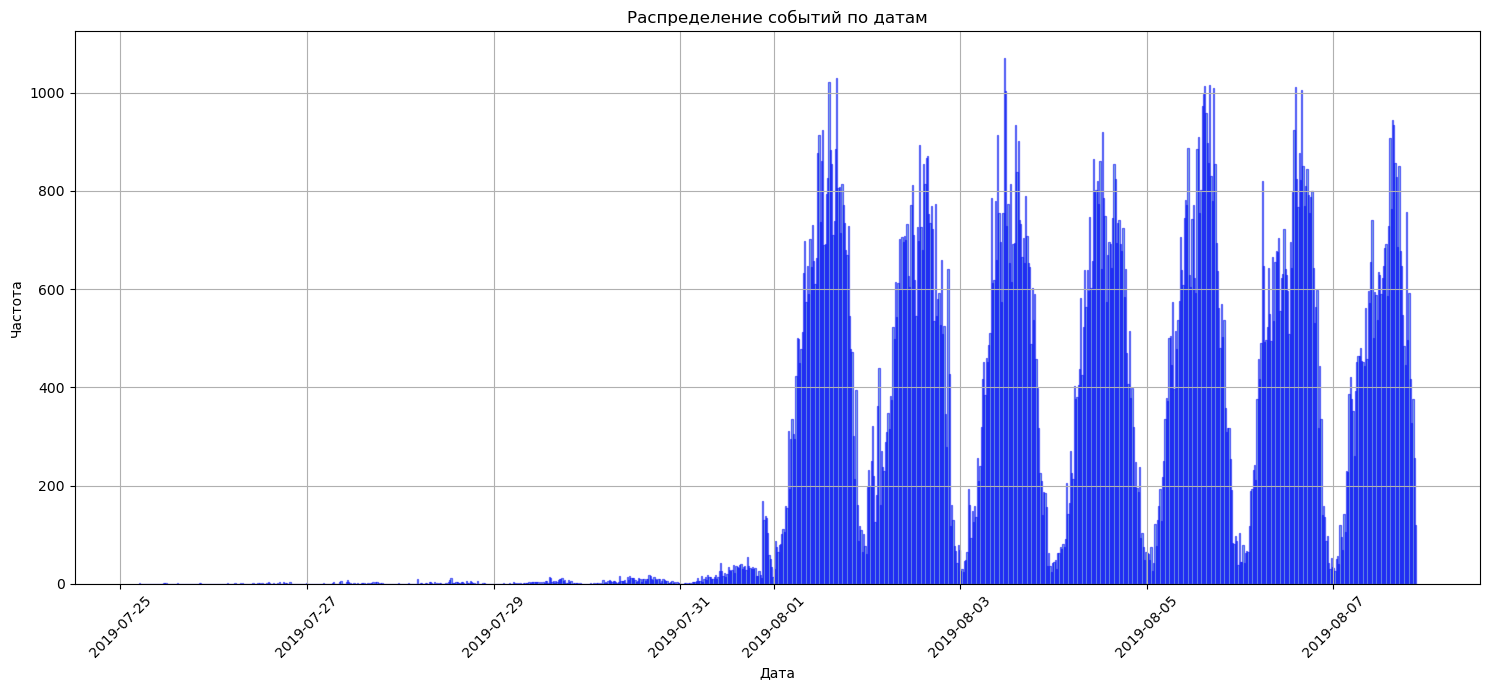

In [51]:
plt.figure(figsize=(15, 7)) 
plt.hist(log['date_time'], bins=1000, edgecolor='blue', alpha=0.5)
plt.title('Распределение событий по датам')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.grid(True) 
plt.show()

Видим, что данные не одинаково полные, с 25.07 по 01.08 очень мало данных по сравнению с остальными днями эксперимента. Уберем эти дни

In [52]:
new = log.query("date > '2019-07-31'")
new.nunique()

event_name              5
device_idhash        7534
event_timestamp    174044
exp_id                  3
date_time          174044
date                    7
dtype: int64

Видим, что дат осталось всего 7

In [54]:
new = log.query("date > '2019-07-31'")
new.nunique()

event_name              5
device_idhash        7534
event_timestamp    174044
exp_id                  3
date_time          174044
date                    7
dtype: int64

In [55]:
print(
    '\n Количество событий после чистки данных:', new.shape[0],
    '\n Количество потеряных событий:', log.shape[0] - new.shape[0],
    '\n % потеряли:', round((log.shape[0] - new.shape[0])/log.shape[0]*100, 2)
     )

print(
    '\n Количество пользователей после чистки данных:', len(new['device_idhash'].unique()),
    '\n Количество потеряных пользователей:', len(log['device_idhash'].unique()) - len(new['device_idhash'].unique()),
    '\n % потеряли:', round((len(log['device_idhash'].unique()) - len(new['device_idhash'].unique())) / log['device_idhash'].nunique()*100, 2))


 Количество событий после чистки данных: 240887 
 Количество потеряных событий: 2826 
 % потеряли: 1.16

 Количество пользователей после чистки данных: 7534 
 Количество потеряных пользователей: 17 
 % потеряли: 0.23


Видим, что потеряли 2826 событий - это 1,16% и 17 пользователей - это 0,23%. Потерянные данные менее 5%, следовательно потери допустимы

Проверим, что после фильтрации остались представители всех трех групп

In [56]:
group = new.groupby('exp_id')['device_idhash'].nunique()
group

exp_id
246    2484
247    2513
248    2537
Name: device_idhash, dtype: int64

### Изучаем воронку

In [57]:
log['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

MainScreenAppear - главный экран \
PaymentScreenSuccessful - оплата успешная \
CartScreenAppear - корзина \
OffersScreenAppear - офферта \
Tutorial - инструкция 

Посмотрим до какого экрана сколько пользователей дошло

In [58]:
new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Сгруппируем данные по событиям и уникальным пользователям. 

In [59]:
event_user = (
        new.groupby('event_name').agg({'event_name':'count', 'device_idhash': 'nunique'})
        .rename(columns={'event_name':'event_cnt', 'device_idhash':'user_cnt'})
        .sort_values(by ='event_cnt', ascending=False).reset_index())

Посмотрим сколько процентов от общего числа дошли до каждой страницы

In [60]:
event_user['step'] = event_user['user_cnt'].shift()
event_user['convers_step'] = round(event_user['user_cnt'] / event_user['step'] * 100, 1) 
event_user.drop(columns= ['step'], axis = 1, inplace = True) #удаляем столбец step
event_user = event_user.fillna(100) # Заменbv NaN в первой строке на 100% 

event_user

,event_name,event_cnt,user_cnt,convers_step
0,MainScreenAppear,117328,7419,100.0
1,OffersScreenAppear,46333,4593,61.9
2,CartScreenAppear,42303,3734,81.3
3,PaymentScreenSuccessful,33918,3539,94.8
4,Tutorial,1005,840,23.7


Видим, что главную страницу посетило 98,5%, оффер прочитали 61%, в корзину зашли уже 49,6%, а до успешной оплаты дошли 47%. Меньше половины пользователей. Так же видим, что наиболее сложным шагом является ознакомление с оффером, так как ее проходят всего 61,9%. Возможно страница сложная для восприятия.

Визуализируем данные

In [62]:
filtered_data = event_user[event_user['event_name'] != 'Tutorial']

fig2 = go.Figure(go.Funnel(
    x=filtered_data['user_cnt'],
    y=filtered_data['event_name'],
    orientation='h',
    textposition="inside",
    
))
fig2.update_layout(
    title="Воронка событий",
    font=dict(size=12),
    width=1000,
    height=500)

fig2.show()

#### Вывод по разделу

Изучили воронки. Видим, что не все пользователи заходят на главный экран ( возможно есть вариант перехода к другим этапам минуя его) \
До покупки доходит всего 47%. 

Так же видим, что страницу с инструкцией посещают крайне редко. Возможно к ней обращаются только в каких-то сложных случчаях.

Предположительный порядок этапов и детализация по событиям:

Главная страница - событий - 117328, пользователей - 7419 \
Страница с предложениями - событий - 46333, пользователей - 4593 \
Корзина - событий - 42303, пользователей - 3734 \
Оплата - событий - 33918, пользователей - 3539 \

Страница с Инструкцией - событий - 1005, пользователей  - 840 - ее посещают очень мало клиентов. Из этого можно сделать вывод, что вероятно она не обязательная.



### Изучим результаты эксперимента

Посчитаем сколько событий в каждой группе

In [63]:
new['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Посчитаем кол-во клиентов в каждой группе

In [64]:
new.groupby('exp_id')['device_idhash'].nunique().sort_values(ascending=False)

exp_id
248    2537
247    2513
246    2484
Name: device_idhash, dtype: int64

Явной разницы по кол-ву между группами не наблюдается, но больше всего пользователей в экспериментальной группе

Проверим, что пользователи в группах не повторяются

In [65]:
user_group_counts = new.groupby('device_idhash')['exp_id'].nunique()
users_in_group = user_group_counts[user_group_counts > 1].index.tolist()
print(f"Повторяющиеся пользователи в группах: {len(users_in_group)}")

Повторяющиеся пользователи в группах: 0


Создадим функцию, которая сгруппирует данные по воронке и кол-ву пользователей

In [66]:
def event_group_piv(group):
    result = (
        new
        .query('exp_id == @group and event_name != "Tutorial"')
        .groupby('event_name')
        .agg(device_count=('device_idhash', 'nunique'))
        .sort_values(by='device_count', ascending=False)
        .reset_index()
    )
    return result

#функция, которая будет счиатть долю пользователей
def event_group_per_us(df):
    unique_devices = new['device_idhash'].nunique()
    df['ratio'] = round((df['device_count'] / unique_devices), 3)

Создадим сводную таблицу для каждой группы

In [67]:
event_246_pivot = event_group_piv(246)
event_group_per_us(event_246_pivot)
event_246_pivot.columns = ['event_name', '246', '246_per_us']

event_247_pivot = event_group_piv(247)
event_group_per_us(event_247_pivot)
event_247_pivot.columns = ['event_name', '247', '247_per_us']

event_248_pivot = event_group_piv(248)
event_group_per_us(event_248_pivot)
event_248_pivot.columns = ['event_name', '248', '248_per_us']

Объеленим три таблицы в одну

In [68]:
event_group_pivot = (
    event_246_pivot
    .merge(event_247_pivot, on='event_name')
    .merge(event_248_pivot, on='event_name')
    )

event_group_pivot

,event_name,246,246_per_us,247,247_per_us,248,248_per_us
0,MainScreenAppear,2450,0.325,2476,0.329,2493,0.331
1,OffersScreenAppear,1542,0.205,1520,0.202,1531,0.203
2,CartScreenAppear,1266,0.168,1238,0.164,1230,0.163
3,PaymentScreenSuccessful,1200,0.159,1158,0.154,1181,0.157


Группы почти не различаются между собой

#### Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Сформулируем гипотезы \
Н0 - доли пользователей, побывавших на этапе воронки равны \
Н1 - доли пользователей, побывавших на этапе воронки не равны \
Уровень значимости для А/А теста - 0,01

Создаем функцию для проведения z-теста

In [69]:
def z_test(exp_group_1, exp_group_2, event, alpha):
    
    alpha = alpha
    g1 = new.query('exp_id == @exp_group_1')
    g2 = new.query('exp_id == @exp_group_2')

    successes = np.array([event_group_pivot.query('event_name == @event')[str(exp_group_1)].sum(),
                          event_group_pivot.query('event_name == @event')[str(exp_group_2)].sum()])
    trials = np.array([len(g1['device_idhash'].unique()), len(g2['device_idhash'].unique())])
    
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', round(p_value, 4))
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

In [70]:
z_test(246, 247, 'MainScreenAppear', 0.01)

p-значение:  0.7571
Не получилось отвергнуть нулевую гипотезу


In [71]:
z_test(246, 247, 'OffersScreenAppear', 0.01)

p-значение:  0.2481
Не получилось отвергнуть нулевую гипотезу


In [72]:
z_test(246, 247, 'CartScreenAppear', 0.01)

p-значение:  0.2288
Не получилось отвергнуть нулевую гипотезу


In [73]:
z_test(246, 247, 'PaymentScreenSuccessful', 0.01)

p-значение:  0.1146
Не получилось отвергнуть нулевую гипотезу


Вывод: результаты А/А теста показали, что разделение на группы корректно

#### A/B тест

Добавим в свобдную таблицу стобец в котором будет сумма посетителей из А/А групп

In [74]:
event_group_pivot['246&247'] = (event_group_pivot['246'] + event_group_pivot['247'])
event_group_pivot['246&247'] = event_group_pivot['246&247'].astype('int')
event_group_pivot

,event_name,246,246_per_us,247,247_per_us,248,248_per_us,246&247
0,MainScreenAppear,2450,0.325,2476,0.329,2493,0.331,4926
1,OffersScreenAppear,1542,0.205,1520,0.202,1531,0.203,3062
2,CartScreenAppear,1266,0.168,1238,0.164,1230,0.163,2504
3,PaymentScreenSuccessful,1200,0.159,1158,0.154,1181,0.157,2358


Создадим функцию для сравнения с объедененной группой

In [75]:
def z_test_uni(exp_group_2, event, alpha):
    
    alpha=alpha
    g1 = new.query('exp_id == 246 | exp_id == 247')
    g2 = new.query('exp_id == @exp_group_2')

    successes = np.array([event_group_pivot.query('event_name == @event')['246&247'].sum(),
                          event_group_pivot.query('event_name == @event')[str(exp_group_2)].sum()])
    trials = np.array([len(g1['device_idhash'].unique()), len(g2['device_idhash'].unique())])
    
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    difference = p1 - p2
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', round(p_value, 4))
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу.')

Дальше будем проводить тест с каждой группой тестовой и с объединенной

Главный экран

In [76]:
z_test(246, 248, 'MainScreenAppear', 0.01) 
z_test(247, 248, 'MainScreenAppear', 0.01)
z_test_uni(248, 'MainScreenAppear', 0.01)

p-значение:  0.295
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.4587
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.2942
Не получилось отвергнуть нулевую гипотезу.


На данном шаге доли одинаковые

In [77]:
z_test(246, 248, 'OffersScreenAppear', 0.01)
z_test(247, 248, 'OffersScreenAppear', 0.01)
z_test_uni(248, 'OffersScreenAppear', 0.01)

p-значение:  0.2084
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.9198
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.4343
Не получилось отвергнуть нулевую гипотезу.


На данном шаге доли одинаковые

In [78]:
z_test(246, 248, 'CartScreenAppear', 0.01)
z_test(247, 248, 'CartScreenAppear', 0.01)
z_test_uni(248, 'CartScreenAppear', 0.01)

p-значение:  0.0784
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.5786
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.1818
Не получилось отвергнуть нулевую гипотезу.


На данном шаге доли одинаковые

In [79]:
z_test(246, 248, 'PaymentScreenSuccessful', 0.01)
z_test(247, 248, 'PaymentScreenSuccessful', 0.01)
z_test_uni(248, 'PaymentScreenSuccessful', 0.01)

p-значение:  0.2123
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.7373
Не получилось отвергнуть нулевую гипотезу
p-значение:  0.6004
Не получилось отвергнуть нулевую гипотезу.


И на этом этапе так же доли одинаковые

#### Вывод

1) По результатам А/А теста мы можем судить, что выборки созданы верно \
2) По результатам проверки А/В теста мы можем говорить о том, что изминения в оформлении не оказали значимого влияния на поведение пользователей

### Вывод

В ходе работы было проведено следующее:
    
1) Изучили воронку продаж.

Видим, что не все пользователи заходят на главный экран ( возможно есть вариант перехода к другим этапам минуя его)
До покупки доходит всего 47%.

Так же видим, что страницу с инструкцией посещают крайне редко. Возможно к ней обращаются только в каких-то сложных случчаях.

Предположительный порядок этапов и детализация по событиям:

Главная страница - событий - 117328, пользователей - 7419
Страница с предложениями - событий - 46333, пользователей - 4593
Корзина - событий - 42303, пользователей - 3734
Оплата - событий - 33918, пользователей - 3539
Инструкция - событий - 1005, пользователей - 840

2) После этого исследовли результаты A/A/B-эксперимента. Анализ результатов А/А теста показал, что разделение на группы корректно. Так как группы не имеют между собой статистически значимой разницы. В дальнейшем было проведено сравнение экспериментальной группы с каждой группой А/А теста, а также совмещенной группой. Результаты показали отсутствие статичстической разницы. 

По итогам исследования можем сделать следующие выводы
На сайте есть проблемы с удобством пользования страницой с предложениями, так как конверсия в следующий шаг на этой странице составляет всего 61,9%. Это приводит к значительному оттоку пользователей.

По итогам A/B теста сделали вывод о том, что изменение шрифтов на сайте не оказало значительного влияния на поведение пользователей.



